<a href="https://colab.research.google.com/github/HeadOutii/AIRepair/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install tensorflow numpy pandas matplotlib opencv-python kaggle

In [2]:
# Импорт необходимых библиотек
import kagglehub
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [3]:
path = kagglehub.dataset_download("bharatadhikari/humanface8000")
print("Path to dataset files:", path)
image_folder = os.path.join(path, 'landscape Images/gray')
mask_folder = os.path.join(path, 'landscape Images/color')

100%|██████████| 475M/475M [00:06<00:00, 72.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bharatadhikari/humanface8000/versions/1


In [4]:
IMAGE_SIZE = (128, 128)
NUM_IMAGES = 8000
BATCH_SIZE = 64
EPOCHS = 20

In [5]:
# ЗАгрузка изображений из папки
def load_images(folder, num_images, target_size):

    images = []
    for filename in os.listdir(folder)[:num_images]:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, target_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return np.array(images)

In [6]:
# Загрузка набора данных
gray_images = load_images(os.path.join(image_folder), NUM_IMAGES, IMAGE_SIZE)
color_images = load_images(os.path.join(mask_folder), NUM_IMAGES, IMAGE_SIZE)

In [7]:
# Нормализация
gray_images = gray_images.astype('float32') / 255.0
color_images = color_images.astype('float32') / 255.0

In [8]:
# Разделение набора данных на обучающие и тестовые наборы
X_train, X_test, y_train, y_test = train_test_split(gray_images, color_images, test_size=0.2, random_state=42)

In [9]:
def create_autoencoder_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Bottleneck
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)

    # Decoder
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = models.Model(inputs, outputs)
    return model

model = create_autoencoder_model((IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
model.compile(optimizer='adam', loss='mean_squared_error')

In [10]:
# Обучнений модели
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test)
)

Epoch 1/20
  1/100 ━━━━━━━━━━━━━━━━━━━━ 59:45 36s/step - loss: 0.0869

KeyboardInterrupt: 

In [ ]:
# Сохранение модели
model.save('image_restoration_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


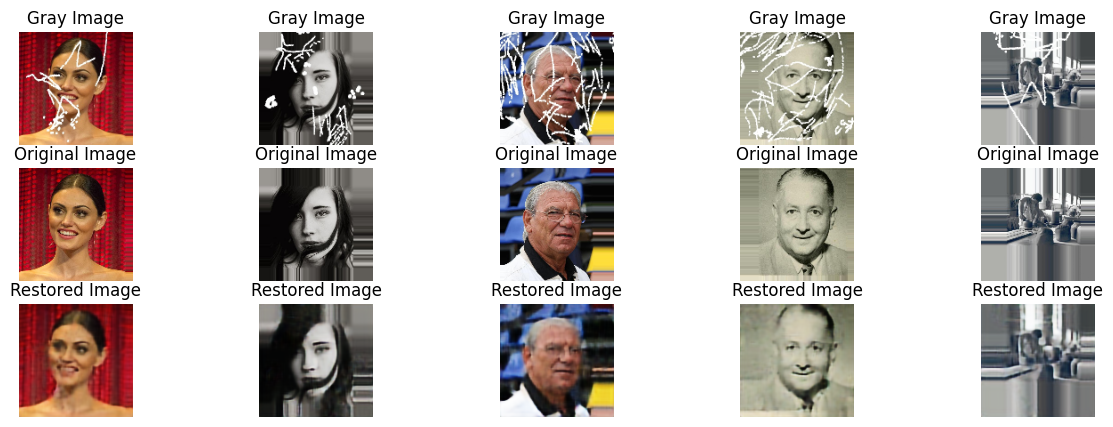

In [ ]:
# Визуализация
def visualize_results(X_test, y_test, model, num_images=5):

    preds = model.predict(X_test[:num_images])

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(3, num_images, i + 1)
        plt.imshow(X_test[i])
        plt.title("Gray Image")
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(y_test[i])
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(preds[i])
        plt.title("Restored Image")
        plt.axis('off')

    plt.show()

visualize_results(X_test, y_test, model)